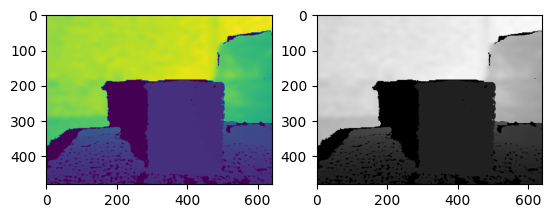

In [33]:
import imageio as iio
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import random
import pyransac3d as pyrsc
import cv2

depth_image = np.load('depth_img.npy')
rgb_image = imageio.v2.imread('rgb.png')
fig, axs = plt.subplots(1, 2)
axs[0].imshow(depth_image)
axs[1].imshow(np.array(256 * depth_image / 0x0fff,dtype=np.uint8), cmap="gray")
plt.show()

In [30]:
FX_DEPTH = 211.348495
FY_DEPTH = 211.348495
CX_DEPTH = 212.030106
CY_DEPTH = 117.634529

height, width = depth_image.shape

depth_grayscale = np.array(256 * depth_image / 0x0fff, dtype=np.uint8)
depth_grayscale = np.stack((depth_grayscale,) * 3, axis=-1)

jj = np.tile(range(width), height).reshape((height, width))
ii = np.repeat(range(height), width).reshape((height, width))

xx = (jj - CX_DEPTH) / FX_DEPTH
yy = (ii - CY_DEPTH) / FY_DEPTH
organized_pcd = np.dstack((xx * depth_image, yy * depth_image, depth_image))


THRESHOLD = 1365 
y_max = max(organized_pcd.reshape((height * width, 3)), key=lambda x: x[1])[1]

pcd = []
for i in range(height):
    for j in range(width):
        if organized_pcd[i][j][1] >= y_max - THRESHOLD:
            depth_grayscale[i][j] = [0, 255, 0]
        elif (organized_pcd[i][j][2] >= 282) & (organized_pcd[i][j][2] <= 300):
            depth_grayscale[i][j] = [150, 15, 15] 
            z = depth_image[i][j]
            x = (j - CX_DEPTH) * z / FX_DEPTH
            y = (i - CY_DEPTH) * z / FY_DEPTH
            pcd.append([x, y, z])
            
# Display depth_grayscale:
plt.imshow(depth_grayscale)
plt.show()

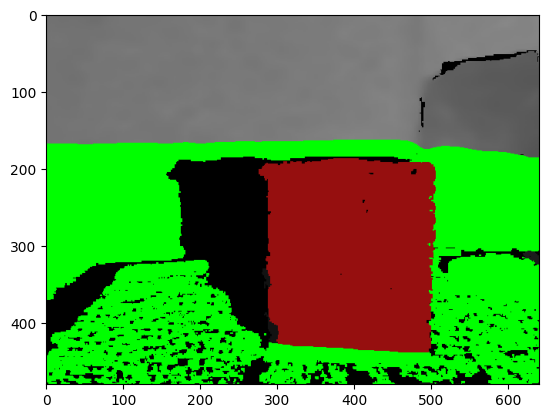

In [31]:
pcd = []
for i in range(height):
    for j in range(width):
        if organized_pcd[i][j][1] >= y_max - THRESHOLD:
            depth_grayscale[i][j] = [0, 255, 0]  # Update the depth image

        # let's filter by the depth
        elif (organized_pcd[i][j][2] >= 282) & (organized_pcd[i][j][2] <= 300):
            # Mark the object
            depth_grayscale[i][j] = [150, 15, 15] 

            # Add coordinates to point cloud
            z = depth_image[i][j]
            x = (j - CX_DEPTH) * z / FX_DEPTH
            y = (i - CY_DEPTH) * z / FY_DEPTH
            pcd.append([x, y, z])
            
# Display depth_grayscale:
plt.imshow(depth_grayscale)
plt.show()


In [32]:
np_pcd = np.array(pcd)
plane1 = pyrsc.Plane()
best_eq, best_inliers = plane1.fit(np_pcd, 282)

# https://miro.medium.com/max/1400/1*66oSaqgHSz33NVsVikwGPg.png
print(f'Plane eqution: {best_eq[0]}x + {best_eq[1]}y + {best_eq[2]}z + {best_eq[3]} = 0')

print('So the distance from the origin to the object is about ' +
      f'{best_eq[3]/np.sqrt(best_eq[0] ** 2 + best_eq[1] ** 2 + best_eq[2] ** 2)} mm')


Plane eqution: -0.48967294642258846x + -0.08130720805849136y + 0.8681068732935789z + -127.45574038568301 = 0
So the distance from the origin to the object is about -127.45574038568303 mm
